# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Read Datasets 
# research_data = pd.read_csv('Datasets/BlockChain_Train_csv.csv')
# research_data.head()

# Read Datasets 
research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')
# Drop unnecessary columns
research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [4]:
research_data.tail()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
1803,2014-05-22,BTCUSD,494.77,530.00,494.77,530.00,32.85,16875.67,2.0,200.0
1804,2014-05-21,BTCUSD,493.43,497.67,490.85,494.77,4.24,2092.04,2.0,200.0
1805,2014-05-20,BTCUSD,445.56,498.84,445.56,493.43,25.28,11926.23,2.0,200.0
1806,2014-05-19,BTCUSD,445.56,445.56,445.56,445.56,0.00,0.00,2.0,200.0
1807,2014-05-18,BTCUSD,453.83,453.83,445.56,445.56,2.58,1151.52,2.0,200.0


In [125]:
TIME_STEPS = 15
BATCH_SIZE_OUT = 20 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [126]:
# Normalize and convert DataFrame into ndArray
# train_cols = ["Open","High","Low","Close","Volume USD","Popularity_Normalized"]
#train_cols = ["Close","TransactionsPerBlock","USD_Exchange_Trade_Volume","BlockSize_d","Total_Number_of_Transactions_d","Estimated_Transaction_Value_USD"]
train_cols = ["Close"]

df_train, df_test = train_test_split(research_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train_out = min_max_scaler.fit_transform(x)
x_test_out = min_max_scaler.transform(df_test.loc[:,train_cols])


Train and Test size 1446 362


In [127]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
#     for i in tqdm_notebook(range(dim_0)):
#         x[i] = mat[i:TIME_STEPS+i]
#         y[i] = mat[TIME_STEPS+i, y_col_index]
#     print("length of time-series i/o",x.shape,y.shape)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    #print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [128]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE_OUT
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [129]:
def load_data(x_train, x_test, batch_size):
    x_t, y_t = build_timeseries(x_train, 0) # index of output (3)
    x_t = trim_dataset(x_t, batch_size)
    y_t = trim_dataset(y_t, batch_size)
    x_temp, y_temp = build_timeseries(x_test, 0) # index of output (3)
    x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size),2)
    y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size),2)
    
    return [x_t, y_t, x_val, x_test_t, y_val, y_test_t]

In [130]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [175]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(32, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True))
    generator.add(Dropout(0.7))
    generator.add(LSTM(16, return_sequences=False))
    generator.add(Dense(1))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (20, 15, 32)              4352      
_________________________________________________________________
dropout_44 (Dropout)         (20, 15, 32)              0         
_________________________________________________________________
lstm_26 (LSTM)               (20, 16)                  3136      
_________________________________________________________________
dense_91 (Dense)             (20, 1)                   17        
_________________________________________________________________
activation_3 (Activation)    (20, 1)                   0         
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [176]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=512, batch_input_shape=(148, TIME_STEPS, 1)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (148, 15, 512)            1024      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (148, 15, 512)            0         
_________________________________________________________________
dropout_45 (Dropout)         (148, 15, 512)            0         
_________________________________________________________________
dense_93 (Dense)             (148, 15, 256)            131328    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (148, 15, 256)            0         
_________________________________________________________________
dropout_46 (Dropout)         (148, 15, 256)            0         
_________________________________________________________________
dense_94 (Dense)             (148, 15, 128)            32896     
__________

In [177]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 1)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 15, 1)             0         
_________________________________________________________________
sequential_36 (Sequential)   multiple                  7505      
_________________________________________________________________
sequential_37 (Sequential)   multiple                  165377    
Total params: 172,882
Trainable params: 7,505
Non-trainable params: 165,377
_________________________________________________________________


In [178]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global y_train
    global X_val
    global X_test
    global y_val
    global y_test
    
    
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    #(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    # generator = create_generator()
    # discriminator = create_discriminator()
    # gan = create_gan(discriminator, generator)
    #gan = create_gan2(discriminator, generator)
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            
            #dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            dim_1 = generated_prices.shape[1]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 1))

            #print('Shapes 1')
            #print(noise.shape)
            #print(prices_batch.shape)
            #print(generated_prices.shape)     
            #print(gen_prices.shape)
            #print(prices_batch)
            #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, X_train.shape[2]))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
            #print('Shapes 2')
            #print(X.shape)
            #print(y_dis.shape)
            #print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #print('Shapes 3')
            #print(noise.shape)
            #print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
        if e == 1 or e % 5 == 0:
            # generate synthetic dataset
            gen_samples_set = []
            for batch_idx in range(int(len(X_train) / batch_size)):
            # for batch_idx in range(int(len(X_train) / 100)):
                # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
                #noise= np.random.normal(0,1, [batch_size, 8])
                noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
                generated_data = generator.predict(noise)
                gen_samples_set.append(generated_data)

            gen_samples = np.vstack(gen_samples_set)

In [179]:
#training(400,128)
training(50,128)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  1%|          | 1/128 [00:00<00:16,  7.88it/s]

1: [D loss: 0.652669, acc: 0.474324]  [A loss: 0.711696, acc: 0.100000]
Epoch 2


  1%|          | 1/128 [00:00<00:17,  7.42it/s]

2: [D loss: 0.700011, acc: 0.254054]  [A loss: 0.684564, acc: 0.600000]
Epoch 3


  1%|          | 1/128 [00:00<00:17,  7.31it/s]

3: [D loss: 0.629176, acc: 0.202703]  [A loss: 0.667553, acc: 0.850000]
Epoch 4


  1%|          | 1/128 [00:00<00:17,  7.27it/s]

4: [D loss: 0.648143, acc: 0.193694]  [A loss: 0.615914, acc: 1.000000]
Epoch 5


  1%|          | 1/128 [00:00<00:16,  7.57it/s]

5: [D loss: 0.657264, acc: 0.165766]  [A loss: 0.616037, acc: 1.000000]
Epoch 6


  1%|          | 1/128 [00:00<00:16,  7.67it/s]

6: [D loss: 0.637042, acc: 0.167117]  [A loss: 0.624659, acc: 1.000000]
Epoch 7


  1%|          | 1/128 [00:00<00:17,  7.29it/s]

7: [D loss: 0.671757, acc: 0.493694]  [A loss: 0.747590, acc: 0.000000]
Epoch 8


  1%|          | 1/128 [00:00<00:17,  7.22it/s]

8: [D loss: 0.628521, acc: 0.164414]  [A loss: 0.617365, acc: 1.000000]
Epoch 9


  1%|          | 1/128 [00:00<00:19,  6.68it/s]

9: [D loss: 0.672659, acc: 0.192793]  [A loss: 0.610565, acc: 1.000000]
Epoch 10


  1%|          | 1/128 [00:00<00:16,  7.90it/s]

10: [D loss: 0.645999, acc: 0.284685]  [A loss: 0.650551, acc: 0.950000]
Epoch 11


  1%|          | 1/128 [00:00<00:16,  7.64it/s]

11: [D loss: 0.607845, acc: 0.238288]  [A loss: 0.664374, acc: 1.000000]
Epoch 12


  1%|          | 1/128 [00:00<00:17,  7.47it/s]

12: [D loss: 0.617289, acc: 0.265315]  [A loss: 0.655914, acc: 0.950000]
Epoch 13


  1%|          | 1/128 [00:00<00:15,  7.97it/s]

13: [D loss: 0.608111, acc: 0.167568]  [A loss: 0.639188, acc: 1.000000]
Epoch 14


  1%|          | 1/128 [00:00<00:17,  7.31it/s]

14: [D loss: 0.609759, acc: 0.186486]  [A loss: 0.648767, acc: 1.000000]
Epoch 15


  1%|          | 1/128 [00:00<00:17,  7.27it/s]

15: [D loss: 0.619617, acc: 0.316216]  [A loss: 0.686730, acc: 0.750000]
Epoch 16


  1%|          | 1/128 [00:00<00:17,  7.06it/s]

16: [D loss: 0.605029, acc: 0.268919]  [A loss: 0.620393, acc: 1.000000]
Epoch 17


  1%|          | 1/128 [00:00<00:16,  7.56it/s]

17: [D loss: 0.606846, acc: 0.281982]  [A loss: 0.692393, acc: 0.600000]
Epoch 18


  1%|          | 1/128 [00:00<00:15,  7.97it/s]

18: [D loss: 0.599371, acc: 0.144595]  [A loss: 0.676436, acc: 0.950000]
Epoch 19


  1%|          | 1/128 [00:00<00:20,  6.32it/s]

19: [D loss: 0.619678, acc: 0.296847]  [A loss: 0.688744, acc: 0.600000]
Epoch 20


  1%|          | 1/128 [00:00<00:15,  8.32it/s]

20: [D loss: 0.601534, acc: 0.140991]  [A loss: 0.654318, acc: 1.000000]
Epoch 21


  1%|          | 1/128 [00:00<00:17,  7.29it/s]

21: [D loss: 0.602904, acc: 0.145946]  [A loss: 1.433218, acc: 0.950000]
Epoch 22


  1%|          | 1/128 [00:00<00:14,  8.71it/s]

22: [D loss: 0.604270, acc: 0.142342]  [A loss: 0.645018, acc: 1.000000]
Epoch 23


  1%|          | 1/128 [00:00<00:15,  8.42it/s]

23: [D loss: 0.601766, acc: 0.319369]  [A loss: 0.672783, acc: 0.950000]
Epoch 24


  1%|          | 1/128 [00:00<00:20,  6.12it/s]

24: [D loss: 0.602924, acc: 0.147748]  [A loss: 0.669564, acc: 1.000000]
Epoch 25


  1%|          | 1/128 [00:00<00:15,  7.96it/s]

25: [D loss: 0.612426, acc: 0.279279]  [A loss: 0.669951, acc: 1.000000]
Epoch 26


  1%|          | 1/128 [00:00<00:18,  6.95it/s]

26: [D loss: 0.602354, acc: 0.141892]  [A loss: 0.673563, acc: 1.000000]
Epoch 27


  1%|          | 1/128 [00:00<00:19,  6.49it/s]

27: [D loss: 0.605418, acc: 0.166216]  [A loss: 0.664615, acc: 1.000000]
Epoch 28


  1%|          | 1/128 [00:00<00:21,  5.82it/s]

28: [D loss: 0.597098, acc: 0.135135]  [A loss: 0.644860, acc: 1.000000]
Epoch 29


  1%|          | 1/128 [00:00<00:17,  7.46it/s]

29: [D loss: 0.601413, acc: 0.150000]  [A loss: 0.653289, acc: 1.000000]
Epoch 30


  1%|          | 1/128 [00:00<00:13,  9.64it/s]

30: [D loss: 0.613612, acc: 0.144595]  [A loss: 0.612706, acc: 1.000000]
Epoch 31


  1%|          | 1/128 [00:00<00:23,  5.35it/s]

31: [D loss: 0.601212, acc: 0.160811]  [A loss: 0.667030, acc: 1.000000]
Epoch 32


  1%|          | 1/128 [00:00<00:18,  6.91it/s]

32: [D loss: 0.597219, acc: 0.355856]  [A loss: 0.685249, acc: 0.800000]
Epoch 33


  1%|          | 1/128 [00:00<00:14,  9.05it/s]

33: [D loss: 0.604376, acc: 0.377477]  [A loss: 0.887897, acc: 0.100000]
Epoch 34


  1%|          | 1/128 [00:00<00:16,  7.81it/s]

34: [D loss: 0.599921, acc: 0.174775]  [A loss: 0.657520, acc: 1.000000]
Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

35: [D loss: 0.600577, acc: 0.152252]  [A loss: 0.650280, acc: 1.000000]
Epoch 36


  1%|          | 1/128 [00:00<00:17,  7.23it/s]

36: [D loss: 0.601449, acc: 0.287838]  [A loss: 0.672587, acc: 1.000000]
Epoch 37


  1%|          | 1/128 [00:00<00:15,  7.99it/s]

37: [D loss: 0.598936, acc: 0.137387]  [A loss: 0.664025, acc: 1.000000]
Epoch 38


  1%|          | 1/128 [00:00<00:17,  7.25it/s]

38: [D loss: 0.602442, acc: 0.138288]  [A loss: 0.639974, acc: 1.000000]
Epoch 39


  1%|          | 1/128 [00:00<00:16,  7.73it/s]

39: [D loss: 0.602648, acc: 0.145946]  [A loss: 0.664666, acc: 1.000000]
Epoch 40


  1%|          | 1/128 [00:00<00:16,  7.93it/s]

40: [D loss: 0.601057, acc: 0.215766]  [A loss: 0.672681, acc: 1.000000]
Epoch 41


  1%|          | 1/128 [00:00<00:22,  5.75it/s]

41: [D loss: 0.602382, acc: 0.138288]  [A loss: 0.622144, acc: 1.000000]
Epoch 42


  1%|          | 1/128 [00:00<00:17,  7.43it/s]

42: [D loss: 0.597654, acc: 0.136937]  [A loss: 0.621018, acc: 1.000000]
Epoch 43


  1%|          | 1/128 [00:00<00:15,  8.02it/s]

43: [D loss: 0.603271, acc: 0.219820]  [A loss: 0.664384, acc: 1.000000]
Epoch 44


  1%|          | 1/128 [00:00<00:17,  7.10it/s]

44: [D loss: 0.599255, acc: 0.135135]  [A loss: 0.662003, acc: 1.000000]
Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

45: [D loss: 0.603010, acc: 0.135135]  [A loss: 0.661956, acc: 1.000000]
Epoch 46


  1%|          | 1/128 [00:00<00:16,  7.62it/s]

46: [D loss: 0.600752, acc: 0.139640]  [A loss: 0.655512, acc: 1.000000]
Epoch 47


  1%|          | 1/128 [00:00<00:16,  7.74it/s]

47: [D loss: 0.605041, acc: 0.137838]  [A loss: 0.654945, acc: 1.000000]
Epoch 48


  1%|          | 1/128 [00:00<00:18,  7.00it/s]

48: [D loss: 0.605879, acc: 0.135586]  [A loss: 0.659228, acc: 1.000000]
Epoch 49


  1%|          | 1/128 [00:00<00:21,  5.96it/s]

49: [D loss: 0.605170, acc: 0.285135]  [A loss: 0.675622, acc: 1.000000]
Epoch 50


100%|██████████| 128/128 [00:17<00:00,  7.50it/s]

50: [D loss: 0.601379, acc: 0.138739]  [A loss: 0.661131, acc: 1.000000]


In [180]:
# generated_data = np.transpose(gen_samples)
# #print(gen_samples)
# #print(generated_data)
# #plot the log-returns
# gen_ind = 1 # change in function price as well
# pd.DataFrame(gen_samples).plot()

In [181]:
def get_2D_array_values(arr, idx):
    arr_map = []
    for i in range(len(arr)):
        arr_map.append(arr[i][idx])
    
    return arr_map

Text(0,0.5,'Loss')

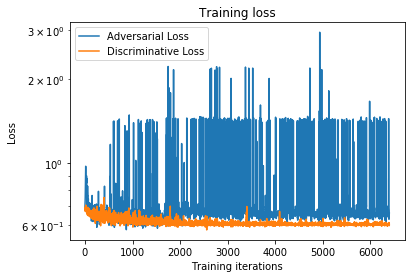

In [182]:
adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss_map,
        'Discriminative Loss': discrimator_loss_map,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

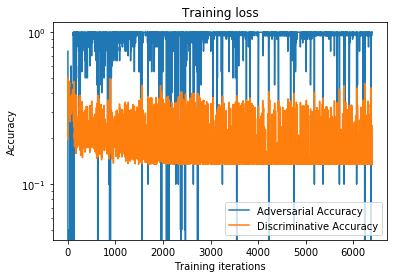

In [183]:
adversarial_acc_map = get_2D_array_values(adversarial_loss, 1)
discrimator_acc_map = get_2D_array_values(discrimator_loss, 1)

ax_acc = pd.DataFrame(
    {
        'Adversarial Accuracy': adversarial_acc_map,
        'Discriminative Accuracy': discrimator_acc_map,
    }
).plot(title='Training loss', logy=True)
ax_acc.set_xlabel("Training iterations")
ax_acc.set_ylabel("Accuracy")

In [184]:
#(X_train2, X_test2, y_train2, y_test2) = load_data_with_test2()
#(X_train2, y_train2, X_val2, X_test2, y_val2, y_test2) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

# print(x_train_out.shape)
# print(x_test_out.shape)

# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

prediction_gan = gan.predict(X_test)

# print("The Explained Variance: %.2f" % prediction_gan.score(X_test2, y_test2))  
print("The Explained Variance: %.2f" % metrics.explained_variance_score(y_test, prediction_gan))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test, prediction_gan))  
#print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test2, prediction_gan)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test, prediction_gan)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test, prediction_gan))))

#generator.predict(X_train)[0]

The Explained Variance: -0.00
The Mean Absolute Error: 0.50
The Mean Squared Error: 0.25
The Root Mean Squared Error: 0.50


In [185]:
y_pred = gan.predict(trim_dataset(X_test, BATCH_SIZE_OUT), batch_size=BATCH_SIZE_OUT)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test, BATCH_SIZE_OUT)
error = metrics.mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.2502796779071502 (160,) (160,)
[0.5154999  0.5154999  0.5154998  0.5154999  0.51550007 0.5155001
 0.5155003  0.51550055 0.5155008  0.515501   0.5155012  0.5155015
 0.5155016  0.5155017  0.5155018 ]
[0.00744447 0.00718329 0.00718329 0.00703077 0.00707883 0.00604458
 0.00587743 0.00587743 0.00582206 0.00561626 0.00707621 0.0069754
 0.00640343 0.0079736  0.00793025]


In [186]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_pred_org = (y_pred + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
#y_test_t_org = (y_test_t + min_max_scaler.data_min_[0])
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[10081.427 10081.427 10081.425 10081.427 10081.431 10081.432 10081.435
 10081.439 10081.444 10081.448 10081.452 10081.458 10081.46  10081.461
 10081.463]
[355.   350.   350.   347.08 348.   328.2  325.   325.   323.94 320.
 347.95 346.02 335.07 365.13 364.3 ]


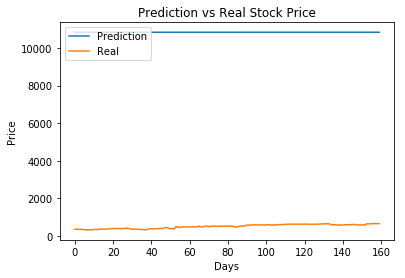

In [173]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
